<h1 align='center'> Diabetes Diagnostic Model Based On Convolutional Neural Network</h1>


-----

|  **Contacts**  ||
|--------------------------|--------
|      **Supervisor**      |  **Dr Md Zakir Hossain**
|        **Student**       |  **Zeyu Zhang**





## I. Import Libraries

In [30]:
# Data Analysis and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

from scipy import stats

#---------------------------------------------------------------------------------

# sklearn for SML

# Logistic Regression
from sklearn.linear_model import LogisticRegression  
from sklearn.linear_model import LogisticRegressionCV   # Logistic Regression with Cross Validation

# PCA
from sklearn.decomposition import PCA 

# t-SNE
from sklearn.manifold import TSNE

# KNN
from sklearn.neighbors import KNeighborsClassifier  

# SVM
from sklearn.svm import SVC

# encoding variables
from sklearn.preprocessing import LabelEncoder 

# Standard Scaler 
from sklearn.preprocessing import StandardScaler       

# data split
from sklearn.model_selection import train_test_split 

# Resample unbalanced data
from sklearn.utils import resample

# nominal variable
#from sklearn.preprocessing import OneHotEncoder

# metrics
from sklearn import metrics
# Validation scoring
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
# import sklearn metrics for validation
import sklearn.metrics as skm
# cross validation
from sklearn.model_selection import cross_validate 

# import cdist for SSE (Distortion)
from scipy.spatial.distance import cdist


# decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor      
from sklearn import tree                               

# KMeans Clustering
from sklearn.cluster import KMeans                     


# ignore warnings
import warnings
warnings.filterwarnings('ignore')


#---------------------------------------------------------------------------------

# PyTorch for DL

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as trans
import torch.nn.functional as F

#---------------------------------------------------------------------------------

# Keras for DL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# !pip install torchmetrics
# from torchmetrics import ConfusionMatrix # Confusion matrix for validation

from numpy import loadtxt
import tensorflow as tf
from tensorflow import keras

#---------------------------------------------------------------------------------

# Grid Search
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier






## II. KNN Classifier & Validation

The reason why we choose KNN is that it is very efficient unless the input data is high-dimensional.

This section includes:

- **Spliting** dataframe for training, testing and validation
- **Scaling** the predictor to normalize the impact factor, since each predictor has a different degree of impact on the outcome
    - Here, we use `StandardScaler()` to achieve this, we can also use `heatmap` alternatively.
- Finding the **Optimal K** for knn model based on iteration
- **Training** KNN model
- Creating a **validation** set
- **Output** the validation, training and testing scores for the best model

In [31]:
# Method StandardScaler()

def data_split(data):
    
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]
    
    train_x, test_x, train_y, test_y = train_test_split(X,y,test_size = 0.2, random_state=0)
    return train_x, test_x, train_y, test_y

def data_scaling(train_x, test_x):

    ss = StandardScaler()
    ss_model = ss.fit(train_x)
    train_x_scaled = ss_model.transform(train_x)
    test_x_scaled = ss_model.transform(test_x)
    return train_x_scaled, test_x_scaled

def knn_classifier(df):
    train_x, test_x, train_y, test_y = data_split(df)
    train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)
    #-------------------------
    # find the optimal K
    # create a validation set
    train_x_scaled, val_x_scaled, train_y, val_y = train_test_split(train_x_scaled,train_y, test_size=0.2, random_state=0)

    best_k = -1
    best_score = -1
    for k in [1,2,3,5,7,9,15,31,51,train_x_scaled.shape[0]]:
        knn = KNeighborsClassifier(n_neighbors=k)    # just change the n_neighbors parameter
        knn_model = knn.fit(train_x_scaled, train_y) # scaled X, un-scaled y
        train_score = knn.score(train_x_scaled, train_y)
        val_score = knn.score(val_x_scaled, val_y)
        print("k:", k, "Training Score:", train_score, "Validation Score: ", val_score)
        # find the best k
        if best_score <= val_score:
            best_score = val_score
            best_model = knn_model
            best_k = k
    
    tn, fp, fn, tp = confusion_matrix(test_y, best_model.predict(test_x_scaled)).ravel()
    print(f'The best k is {best_k} and the best val score is {best_score:.4f}')


    # Print the validation, training and testing scores for the best model  
    print("Best Model Validation Score: {:.4f}".format(best_model.score(val_x_scaled, val_y)), 
    "\n Training Score: {:.4f}".format(best_model.score(train_x_scaled, train_y)),
    "\n Test Score: {:.4f}".format(best_model.score(test_x_scaled, test_y)))
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

## III. Logistic Regression with 5 Fold Cross Validation

The reason why we choose Logistic Regression is that it's one of the most suitable classifier for binomial classification.

In [32]:
def lg_classifier(df):
    train_x, test_x, train_y, test_y = data_split(df)
    mdl = LogisticRegressionCV(cv=5, multi_class='ovr', random_state=0).fit(train_x, train_y)
    tn, fp, fn, tp = confusion_matrix(test_y, mdl.predict(test_x)).ravel()


    print("Training Accuracy:", mdl.score(train_x, train_y))
    print("Testing Accuracy:", mdl.score(test_x, test_y))
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))


## IV. SVM

In [33]:
def svm(df):
  train_x, test_x, train_y, test_y = data_split(df)
  mdl = SVC(kernel='linear').fit(train_x, train_y)
  tn, fp, fn, tp = confusion_matrix(test_y, mdl.predict(test_x)).ravel()

  print("Training Accuracy:", mdl.score(train_x, train_y))
  print("Testing Accuracy:", mdl.score(test_x, test_y))
  print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))


## V. Screening of Datasets

First we need to study the correlation between the predictors and outcomes. In order to find the appropriate dataset as the research object, the screening of multiple is indispensable.  


### Canidate Data Sources

- **`CDC_BRFSS2015`** - It's a dataset of 253,680 survey responses to the CDC's BRFSS2015.
- **`NIDDK_Pima`** - It's a dataset of 768 females at least 21 years old of Pima Indian heritage responses to National Institute of Diabetes and Digestive and Kidney Diseases's survey.
- **`Sylhet`** - This dataset has been collected using direct questionnaires from 520 patients of Sylhet Diabetes Hospital in Sylhet, Bangladesh.
- **`BIT_2019`** - This dataset was collected in 2019 by Neha Prerna Tigga and Dr. Shruti Garg of the Department of Computer Science and Engineering, BIT Mesra
- **`John`** - These data are courtesy of Dr John Schorling, Department of Medicine, University of Virginia School of Medicine. The data consist of 19 variables on 403 subjects from 1046 subjects who were interviewed in a study to understand the prevalence of obesity, diabetes, and other cardiovascular risk factors in central Virginia for African Americans. 

- **`John_2`** - We also keep another version of Diabetes data of Dr John Schorling

-----





## 1. CDC BRFSS2015 Database

This is a clean dataset of 253,680 survey responses to the CDC's BRFSS2015 with 22 features. These features are either questions directly asked of participants, or calculated variables based on individual participant responses.

####  Attribute Information
| Column Name    | Expression    |
| :------------- | :------------- |
| Diabetes_binary| 0 = no diabetes 1 = diabetes |
| HighBP      | 0 = no high BP 1 = high BP |
| HighChol    | 0 = no high cholesterol 1 = high cholesterol |
| CholCheck       | 0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years |
| BMI            | Body Mass Index |
| Smoker      | Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes |
| Stroke       | (Ever told) you had a stroke. 0 = no 1 = yes |
| HeartDiseaseorAttack        | coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes |
| PhysActivity       | physical activity in past 30 days - not including job 0 = no 1 = yes |
| Fruits        | Consume Fruit 1 or more times per day 0 = no 1 = yes |
| Veggies        | Consume Vegetables 1 or more times per day 0 = no 1 = yes |
| HvyAlcoholConsump        | (adult men >=14 drinks per week and adult women>=7 drinks per week) 0 = no 1 = yes |
| AnyHealthcare        | Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes |
| NoDocbcCost        | Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes |
| GenHlth       | Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor |
| MentHlth        | days of poor mental health scale 1-30 days |
| PhysHlth        | physical illness or injury days in past 30 days scale 1-30 |
| DiffWalk        | Do you have serious difficulty walking or climbing stairs? 0 = no 1 = yes |
| Sex        | 0 = female 1 = male |
| Age        | 13-level age category 1 = 18-24 9 = 60-64 13 = 80 or older |
| Education        | Education level scale 1-6 1 = Never attended school or only kindergarten 2 = elementary etc. |
| Income        | Income scale 1-8 1 = less than `$10000`, 5 = less than `$35000`, 8 = `$75000` or more |





#### Loading data





In [74]:
# Read 'CDC_BRFSS2015.csv'
cdc_df = pd.read_csv("./data/CDC_BRFSS2015.csv")

# Drop NaN value
print("Any null value:", any(cdc_df.isnull()))
print("Any NaN value:", any(cdc_df.isna()))
print("Before Droping NaN Number of Rows:", len(cdc_df))

cdc_df = cdc_df.dropna()
print("After Droping NaN Number of Rows:", len(cdc_df))

# Move 'Diabetes_binary' column to the end of dataframe
cdc_df['Diabetes_binary'] = cdc_df.pop('Diabetes_binary')

cdc_df.tail()



Any null value: True
Any NaN value: True
Before Droping NaN Number of Rows: 253680
After Droping NaN Number of Rows: 253680


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
253675,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0,0.0
253676,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0,1.0
253677,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0,0.0
253678,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0,0.0
253679,1.0,1.0,1.0,25.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,9.0,6.0,2.0,1.0


---
#### Data Balance

In [35]:
print((cdc_df.Diabetes_binary == 0).sum())
print((cdc_df.Diabetes_binary == 1).sum())

218334
35346


(1) Oversample

In [ ]:
# Oversample
#create two different dataframe of majority and minority class 
df_majority = cdc_df[(cdc_df['Diabetes_binary']==0)] 
df_minority = cdc_df[(cdc_df['Diabetes_binary']==1)] 
# oversample minority class
df_minority_oversample = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 218334, # to match majority class
                                 random_state=42)  # reproducible results
# Combine
cdc_df = pd.concat([df_minority_oversample, df_majority])

# Shuffle
cdc_df = cdc_df.sample(frac=1).reset_index(drop=True)

In [ ]:
print((cdc_df.Diabetes_binary == 0).sum())
print((cdc_df.Diabetes_binary == 1).sum())

218334
218334


(2) Undersample

In [75]:
# Undersample
#create two different dataframe of majority and minority class 
df_majority = cdc_df[(cdc_df['Diabetes_binary']==0)] 
df_minority = cdc_df[(cdc_df['Diabetes_binary']==1)] 
# oversample minority class
df_majority_undersample = resample(df_majority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 35346, # to match minority class
                                 random_state=42)  # reproducible results
# Combine
cdc_df = pd.concat([df_majority_undersample, df_minority])

# Shuffle
cdc_df = cdc_df.sample(frac=1).reset_index(drop=True)

In [37]:
print((cdc_df.Diabetes_binary == 0).sum())
print((cdc_df.Diabetes_binary == 1).sum())

35346
35346


In [63]:
# Correlation contingency table
cdc_corr = cdc_df.corr()
cdc_corr

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
HighBP,1.000000,0.311236,0.099884,0.236281,0.089950,0.126744,0.208756,-0.135254,-0.040702,-0.070827,...,0.028051,0.321972,0.065890,0.170594,0.233808,0.042522,0.338744,-0.146916,-0.189234,0.376526
HighChol,0.311236,1.000000,0.083554,0.127300,0.095690,0.094960,0.179297,-0.093568,-0.047099,-0.045464,...,0.033963,0.240876,0.087067,0.143679,0.163677,0.017362,0.242178,-0.083378,-0.109895,0.286841
CholCheck,0.099884,0.083554,1.000000,0.042715,0.000212,0.021334,0.041997,0.001372,0.019675,0.002930,...,-0.048852,0.055604,-0.006995,0.032952,0.045078,-0.012597,0.096109,-0.007685,0.001493,0.111563
BMI,0.236281,0.127300,0.042715,1.000000,0.016177,0.023881,0.060535,-0.170975,-0.088202,-0.062403,...,0.068475,0.267767,0.108843,0.162341,0.242992,-0.000057,-0.043518,-0.105073,-0.128645,0.285256
Smoker,0.089950,0.095690,0.000212,0.016177,1.000000,0.056371,0.121253,-0.078780,-0.073219,-0.026060,...,0.035422,0.148567,0.089474,0.113456,0.116286,0.113016,0.108172,-0.133464,-0.104473,0.088019
Stroke,0.126744,0.094960,0.021334,0.023881,0.056371,1.000000,0.222207,-0.076980,-0.016357,-0.046955,...,0.035878,0.188516,0.081412,0.162759,0.190998,0.001387,0.123750,-0.076382,-0.135411,0.122279
HeartDiseaseorAttack,0.208756,0.179297,0.041997,0.060535,0.121253,0.222207,1.000000,-0.099269,-0.021003,-0.037118,...,0.034954,0.279887,0.076207,0.198494,0.236190,0.097965,0.220956,-0.100573,-0.148558,0.209694
PhysActivity,-0.135254,-0.093568,0.001372,-0.170975,-0.078780,-0.076980,-0.099269,1.000000,0.131511,0.150867,...,-0.062051,-0.278534,-0.134311,-0.239389,-0.279045,0.056067,-0.102783,0.194089,0.200856,-0.158864
Fruits,-0.040702,-0.047099,0.019675,-0.088202,-0.073219,-0.016357,-0.021003,0.131511,1.000000,0.241294,...,-0.042598,-0.099497,-0.062810,-0.044264,-0.052373,-0.090690,0.058032,0.099870,0.077209,-0.055899
Veggies,-0.070827,-0.045464,0.002930,-0.062403,-0.026060,-0.046955,-0.037118,0.150867,0.241294,1.000000,...,-0.035863,-0.117172,-0.052749,-0.069110,-0.085216,-0.052097,-0.018395,0.150039,0.152922,-0.082044


In [68]:
print(cdc_corr.iloc[-1,:].sort_values(ascending=False))

Diabetes_binary         1.000000
GenHlth                 0.407130
HighBP                  0.376526
HighChol                0.286841
BMI                     0.285256
Age                     0.274125
DiffWalk                0.268147
PhysHlth                0.212632
HeartDiseaseorAttack    0.209694
Stroke                  0.122279
CholCheck               0.111563
MentHlth                0.092612
Smoker                  0.088019
Sex                     0.046437
NoDocbcCost             0.045360
AnyHealthcare           0.026085
Fruits                 -0.055899
Veggies                -0.082044
HvyAlcoholConsump      -0.099096
PhysActivity           -0.158864
Education              -0.171768
Income                 -0.228165
Name: Diabetes_binary, dtype: float64


Moreover, we evaluate the Weighted Average of the correlation of predictors:

$\text{Weighted Average of Correlation}$ $=$ $\frac{\text{Sum of Correlation of Predictors}}{\text{Number of Predictors}}$ $=$ $0.098
$


In [ ]:
# Evaluate the Weighted Average of the correlation of predictors

print("Weighted Average:", sum(cdc_corr.iloc[-1,:-1])/21)

Weighted Average: 0.09766407302066364


-----

###  1.1 KNN with PCA

Since it's a considerably large dataset with 253680 tuples and 21 predictors. Although it's not high-dimensional but it's obviously time consuming when training the model on a personal computer.

So in order to address this issue, we should implement Dimensionality Reduction based on Principal Components Analysis (PCA).

To begin with, we have to plot the Explained Variance vs Principal Component Diagraph to determine how many dimensions do we need to keep.



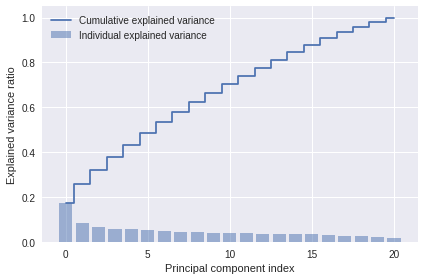

In [ ]:
# Scale the dataset; This is very important before you apply PCA

train_x, test_x, train_y, test_y = data_split(cdc_df)
train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)
train_x_scaled, val_x_scaled, train_y, val_y = train_test_split(train_x_scaled,train_y, test_size=0.2, random_state=0)

# Instantiate PCA
pca = PCA()

# Determine transformed features
X_train_pca = pca.fit_transform(train_x_scaled)

# Determine explained variance using explained_variance_ratio_ attribute
exp_var_pca = pca.explained_variance_ratio_


# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


The more components you include the more variance you explain and the less information you loose but there's a **trade off**.

Ideally, we should choose the number of components to include in the model by adding the explained variance ratio of each component until it reaches a total of around **0.8** to avoid overfitting.

Since we do not have powerful computational resources. We have to select 5 dimensions for the trade-off.

In [ ]:
pca = PCA(n_components = 5).fit(train_x_scaled)

X_train_pca = pca.transform(train_x_scaled)

X_test_pca = pca.transform(test_x_scaled)

X_val_pca = pca.transform(val_x_scaled)

best_k = -1
best_score = -1
for k in [1,2,3,5,7,9,15,31,51,71,91]:
    knn = KNeighborsClassifier(n_neighbors=k)    # just change the n_neighbors parameter
    knn_model = knn.fit(X_train_pca, train_y) # scaled X, un-scaled y
    train_score = knn.score(X_train_pca, train_y)
    val_score = knn.score(X_val_pca, val_y)

    print("k:", k, "Training Score:", train_score, "Validation Score: ", val_score)
    # find the best k
        # find the best k
    if best_score <= val_score:
        best_score = val_score
        best_model = knn_model
        best_k = k

tn, fp, fn, tp = confusion_matrix(test_y, best_model.predict(X_test_pca)).ravel()
print(f'The best k is {best_k} and the best val score is {best_score:.4f}')


# Print the validation, training and testing scores for the best model  
print("Best Model Validation Score: {:.4f}".format(best_model.score(X_val_pca, val_y)), 
"\n Training Score: {:.4f}".format(best_model.score(X_train_pca, train_y)),
"\n Test Score: {:.4f}".format(best_model.score(X_test_pca, test_y)))
print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))


k: 1 Training Score: 0.9954246054551081 Validation Score:  0.6672265935814694
k: 2 Training Score: 0.8308430219707351 Validation Score:  0.6426487490053929
k: 3 Training Score: 0.8291631669687458 Validation Score:  0.6846432676155955
k: 5 Training Score: 0.7901065381724945 Validation Score:  0.6988771991866325
k: 7 Training Score: 0.7760930109190575 Validation Score:  0.7055963221642648
k: 9 Training Score: 0.7664117413023297 Validation Score:  0.7086022456016268
k: 15 Training Score: 0.7536581053003846 Validation Score:  0.7164706922464857
k: 31 Training Score: 0.7450599000928341 Validation Score:  0.7269030147643887
k: 51 Training Score: 0.7399540250209982 Validation Score:  0.7287596145345239
k: 71 Training Score: 0.7386720304142169 Validation Score:  0.7270798337901159
k: 91 Training Score: 0.7381636532425622 Validation Score:  0.7277871098930245
The best k is 51 and the best val score is 0.7288
Best Model Validation Score: 0.7288 
 Training Score: 0.7400 
 Test Score: 0.7431
Testi

####  Validation without PCA (took around 5000s)

Luckily, we can see the trade-off between explained variance and information we keeped based on PCA does not cause to many losses compare with the traditional KNN (21 predictors), as long as we select the optimal K.

---
#### Visualization via PCA to 2-dim

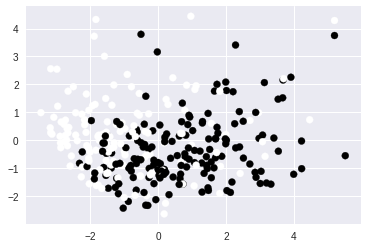

In [ ]:
pca = PCA(n_components = 2).fit(train_x_scaled)

Xt = pca.transform(train_x_scaled)

plot = plt.scatter(Xt[:300,0], Xt[:300,1], c=train_y[:300])
plt.legend(handles=plot.legend_elements()[0])
plt.show()

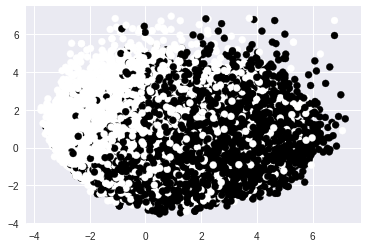

In [ ]:
pca = PCA(n_components = 2).fit(train_x_scaled)

Xt = pca.transform(train_x_scaled)

plot = plt.scatter(Xt[:,0], Xt[:,1], c=train_y)
plt.legend(handles=plot.legend_elements()[0])
plt.show()

-----

###  1.2 Logistic Regression
#### 1.2.1 Without scaling the data

In [38]:
lg_classifier(cdc_df)

Training Accuracy: 0.7446819797358231
Testing Accuracy: 0.7482848857769291
Testing: Sensitivity/Recall: 0.7727850784230607 Specificity: 0.7237326536391957


#### 1.2.2 With scaling the data

In [39]:
train_x, test_x, train_y, test_y = data_split(cdc_df)
train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

mdl = LogisticRegressionCV(cv=5, multi_class='ovr', random_state=0).fit(train_x_scaled, train_y)
tn, fp, fn, tp = confusion_matrix(test_y, mdl.predict(test_x_scaled)).ravel()


print("Training Accuracy:", mdl.score(train_x_scaled, train_y))
print("Testing Accuracy:", mdl.score(test_x_scaled, test_y))
print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))


Training Accuracy: 0.7448234399589765
Testing Accuracy: 0.7481434330575005
Testing: Sensitivity/Recall: 0.7725024727992087 Specificity: 0.7237326536391957


-----

###  1.3 Building a prototype classifier based on BPNN
#### 1.3.1 NN Tuning via Grid Search


We have following hyperparameters to be determined:

![hyperpara](/img/hyperpara.png)

**1. Principles for determining the number of hidden layers** 

![hidden](/img/hidden.jpg)

**2. Principles for determining the number of neurons of hidden layers** 

We have following empirical formulas:

1. $\text{Hidden Neurons}$ $=$ $\frac{\text{Num of Training Data}}{(2 \text{~} 10) {\kern 3pt}*{\kern 3pt} \text{(Input Neurons + Output Neurons)}}$

2. $\text{Hidden Neurons}$ $=$ $\sqrt{\text{Input Neurons * Output Neurons}}$

3. 
  - The number of hidden neurons should be between the size of the input layer and the size of the output layer.
  - The number of hidden neurons should be 2/3 of the size of the input layer plus 2/3 of the size of the output layer.
  - The number of hidden neurons should be less than twice the size of the input layer.


In [ ]:
# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(cdc_df)

train_x = np.float32(train_x)
test_x = np.float32(test_x)

# ------- Normalize the predictors or not ----------
# train_x = train_x/train_x.max()
# test_x = test_x/test_x.max()
# --------------------------------------------------------

def gridNN(layers, activation, optimizer):
  mdl = Sequential()
  for i, neuron in enumerate(layers):
    mdl.add(Dense(neuron, activation = activation))
  mdl.add(Dense(1, activation='sigmoid'))
  mdl.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
  return mdl


mdl = KerasClassifier(build_fn = gridNN)

# Define Hyperparameters

layers = [[2],[4],[6],[8],[16],[32],[64],[4,2],[8,4],[16,8],[32,16],[64,32],[64,32,16],[32,16,8],[16,8,4],[8,4,2]]
activations = ['sigmoid', 'relu', 'softmax']
optimizer = ['SGD', 'Adam']
batch = [8, 16, 32, 64, 128, 256, 512, 1024]
epoch = [10, 50, 100, 200, 500, 1000]

para_grid = dict(layers=layers, activation=activations, optimizer=optimizer, batch_size=batch, epochs=epoch)

grid = GridSearchCV(estimator = mdl, param_grid = para_grid)

print("Training acc:", grid.fit(train_x,train_y).best_score_, grid.fit(train_x,train_y).best_params_)



The above Grid Search code basically explore all hyperparameters and it's considerably time consuming.

Hence, we decided to decomposite it intto small steps.

**1. Finding numbers of hidden layers and neurons**

We first assume that 

| Hyperparameters    | Value    |
| :------------- | :------------- |
| activations| 'relu' |
| optimizer| 'Adam' |
| batch| 1024 |
| epoch| 200 |
| loss| 'binary_crossentropy' |
| scaling or not | No |
| normalize or not | No |
| learning rate| default |
| momentum| default |
| num of output class| 1 |


In [ ]:
# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(cdc_df)

train_x = np.float32(train_x)
test_x = np.float32(test_x)

def gridNN(layers):
  mdl = Sequential()
  for i, neuron in enumerate(layers):
    mdl.add(Dense(neuron, activation = 'relu'))
  mdl.add(Dense(1, activation='sigmoid'))
  mdl.compile(loss='binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
  return mdl


mdl = KerasClassifier(build_fn = gridNN)

# Define Hyperparameters

layers = [[2],[4],[6],[8],[16],[32],[64],[4,2],[8,4],[16,8],[32,16],[64,32],[64,32,16],[32,16,8],[16,8,4],[8,4,2]]

para_grid = dict(layers=layers, batch_size=[1024], epochs=[200])

grid = GridSearchCV(estimator = mdl, param_grid = para_grid, cv =2)

print("Training acc:", grid.fit(train_x,train_y).best_score_, grid.fit(train_x,train_y).best_params_)


at the end we get best hidden layers are `[16, 8]`

**2. Finding batch size and epochs**

We first assume that 

| Hyperparameters    | Value    |
| :------------- | :------------- |
| activations| 'relu' |
| optimizer| 'Adam' |
| loss| 'binary_crossentropy' |
| scaling or not | No |
| normalize or not | No |
| learning rate| default |
| momentum| default |
| num of output class| 1 |

In [ ]:
# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(cdc_df)

train_x = np.float32(train_x)
test_x = np.float32(test_x)

def gridNN():
  mdl = Sequential()
  mdl.add(Dense(16, activation = 'relu'))
  mdl.add(Dense(8, activation = 'relu'))
  mdl.add(Dense(1, activation='sigmoid'))
  mdl.compile(loss='binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
  return mdl


mdl = KerasClassifier(build_fn = gridNN)

# Define Hyperparameters

batch = [8, 16, 32, 64, 128, 256, 512, 1024]
epoch = [10, 50, 100, 200, 500, 1000]

para_grid = dict(batch_size=batch, epochs=epoch)

grid = GridSearchCV(estimator = mdl, param_grid = para_grid, cv=2)

print("Training acc:", grid.fit(train_x,train_y).best_score_, grid.fit(train_x,train_y).best_params_)

at the end we get best epochs are `1000` and batch size is `512`

**3. Finding best activation, optimizer and loss function**

We first assume that 

| Hyperparameters    | Value    |
| :------------- | :------------- |
| scaling or not | No |
| normalize or not | No |
| learning rate| default |
| momentum| default |
| num of output class| 1 |

In [ ]:
# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(cdc_df)

train_x = np.float32(train_x)
test_x = np.float32(test_x)

# ------- Normalize the predictors or not ----------
# train_x = train_x/train_x.max()
# test_x = test_x/test_x.max()
# --------------------------------------------------------

def gridNN(activation, optimizer, loss):
  mdl = Sequential()
  mdl.add(Dense(16, activation = activation))
  mdl.add(Dense(8, activation = activation))
  mdl.add(Dense(1, activation=activation))
  mdl.compile(loss=loss, optimizer = optimizer, metrics=['accuracy'])
  return mdl


mdl = KerasClassifier(build_fn = gridNN)

# Define Hyperparameters

activations = ['sigmoid', 'relu', 'softmax']
optimizer = ['SGD', 'Adam']
loss = ['binary_crossentropy']

para_grid = dict(activation=activations, optimizer=optimizer, batch_size=[512], epochs=[1000], loss = loss)

grid = GridSearchCV(estimator = mdl, param_grid = para_grid, cv=2)

print("Training acc:", grid.fit(train_x,train_y).best_score_, grid.fit(train_x,train_y).best_params_)

at the end we found the best activation is `sigmoid`, optimizer is `Adam` and lossfunction is `'binary_crossentropy'`.

**4. Determine other hyperparameters**

We have the respective outcome below:

| Hyperparameters    | Value    | Training acc    | Testing acc    |
| :------------- | :------------- | :------------- | :------------- |
| No operations | -- |0.7558|0.7517|
| scaling or not | Yes |0.7553|0.7540|
| normalize or not | Yes |0.7463|0.7518|
| learning rate (0.0001,0.0003,0.001,0.003,0.01,0.03)| 0.0001 |0.7530|0.7539|
| momentum| 0.9 |0.6367|0.6499|
| num of output class|2 |0.7562|0.7529|

With these hyperparameters, we can finally build our BPNN.

![bpnn](/img/bpnn.png)



#### 1.3.2 BPNN via Keras

Please note that NNs defined via Keras can automatically fit the shape of input. Hence, we only need to define the hidden layers and output layers. 

Besides, the outcome might be different with or without adding an activation on the output layer.




In [ ]:
# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(cdc_df)

train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

train_x = np.float32(train_x_scaled)
test_x = np.float32(test_x_scaled)


#train_x = train_x/train_x.max()
#test_x = test_x/test_x.max()

model = keras.Sequential([
    keras.layers.Dense(16, activation='sigmoid'),
    keras.layers.Dense(8, activation='sigmoid'),
    keras.layers.Dense(2, activation='sigmoid')
])

opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(train_x, train_y, epochs=1000, batch_size=512, validation_data=(test_x, test_y))

_, accuracy = model.evaluate(train_x, train_y)
print('Training Accuracy:', accuracy)
# evaluate the keras model
_, accuracy = model.evaluate(test_x, test_y)
print('Testing Accuracy:', accuracy)

Epoch 1/1000
111/111 [==============================] - 1s 4ms/step - loss: 0.6993 - accuracy: 0.4906 - val_loss: 0.6934 - val_accuracy: 0.5119
Epoch 2/1000
111/111 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5415 - val_loss: 0.6848 - val_accuracy: 0.5896
Epoch 3/1000
111/111 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.6050 - val_loss: 0.6763 - val_accuracy: 0.6380
Epoch 4/1000
111/111 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.6437 - val_loss: 0.6677 - val_accuracy: 0.6631
Epoch 5/1000
111/111 [==============================] - 1s 5ms/step - loss: 0.6648 - accuracy: 0.6626 - val_loss: 0.6587 - val_accuracy: 0.6767
Epoch 6/1000
111/111 [==============================] - 0s 4ms/step - loss: 0.6559 - accuracy: 0.6749 - val_loss: 0.6494 - val_accuracy: 0.6871
Epoch 7/1000
111/111 [==============================] - 0s 4ms/step - loss: 0.6467 - accuracy: 0.6846 - val_loss: 0.6397 - val_accuracy:

#### 1.3.3 BPNN via Pytorch

In [54]:
# Prepare training and testing data
train_x, test_x, train_y, test_y = data_split(cdc_df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building BPNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.fc3 = nn.Linear(hid2, numclass)
  # feedforward
  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # Activation using sigmoid function for regularization
    x = F.sigmoid(self.fc2(x))
    x = F.sigmoid(self.fc3(x))
    return x

input = train_x.shape[1] 
hid1 = 16
hid2 = 8
numclass = 2
epochs = 1000
batch = 512

modl = bpnn(input, hid1, hid2, numclass)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optim = torch.optim.Adam(modl.parameters(), lr=0.0001)

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y.shape[0]))
  source = train_x[shuffle_indices]
  target = train_y[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch]
    target_batch = target[start_i:start_i + batch]
    train_pred = modl(source_batch)
    train_pred = torch.squeeze(train_pred)
    losses = criterion(train_pred, target_batch.type(torch.LongTensor))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  if (epoch+1) % 200 == 0:
    train_pred_np = torch.argmax(train_pred, axis=1).numpy()
    train_acc = accuracy_score(target_batch, train_pred_np)

    test_pred = modl(test_x)
    test_pred = torch.squeeze(test_pred)

    test_loss = criterion(test_pred, test_y.type(torch.LongTensor))

    test_pred_np = torch.argmax(test_pred, axis=1).numpy()
    test_acc = accuracy_score(test_y, test_pred_np)
    tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()


    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))




Epochs [200/1000]
Training: Losses: 0.5478307009, Accuracy: 0.748046875
Testing: Losses: 0.5504439473, Accuracy: 0.7485677912157861
Testing: Sensitivity/Recall: 0.8035890914229193 Specificity: 0.6934296233361654
Epochs [400/1000]
Training: Losses: 0.5454199910, Accuracy: 0.740234375
Testing: Losses: 0.5479124784, Accuracy: 0.7501944974892142
Testing: Sensitivity/Recall: 0.8028825773632895 Specificity: 0.6973945058057207
Epochs [600/1000]
Training: Losses: 0.5530868769, Accuracy: 0.72265625
Testing: Losses: 0.5449438095, Accuracy: 0.7527406464389278
Testing: Sensitivity/Recall: 0.8004804295605482 Specificity: 0.7048994619088077
Epochs [800/1000]
Training: Losses: 0.5692577362, Accuracy: 0.724609375
Testing: Losses: 0.5435369015, Accuracy: 0.7531650045972134
Testing: Sensitivity/Recall: 0.7980782817578069 Specificity: 0.7081563296516568
Epochs [1000/1000]
Training: Losses: 0.5494416952, Accuracy: 0.74609375
Testing: Losses: 0.5429655313, Accuracy: 0.7542966263526416
Testing: Sensitivity/

#### 1.3.4 Dropout to improve Accuracy

Dropout drops a certain amount of data randomly, result in decreasing of Training Acc, in order to avoid overfitting.

In [ ]:
# Prepare training and testing data
train_x, test_x, train_y, test_y = data_split(cdc_df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building BPNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.dropout1 = nn.Dropout(0.1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.dropout2 = nn.Dropout(0.1)
    self.fc3 = nn.Linear(hid2, numclass)
  # feedforward
  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # Activation using sigmoid function for regularization
    x = self.dropout1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.dropout2(x)
    x = F.sigmoid(self.fc3(x))
    return x

input = train_x.shape[1] 
hid1 = 64
hid2 = 32
numclass = 2
epochs = 1000
batch = 512

modl = bpnn(input, hid1, hid2, numclass)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optim = torch.optim.Adam(modl.parameters(), lr=0.0001)

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y.shape[0]))
  source = train_x[shuffle_indices]
  target = train_y[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch]
    target_batch = target[start_i:start_i + batch]
    train_pred = modl(source_batch)
    train_pred = torch.squeeze(train_pred)
    losses = criterion(train_pred, target_batch.type(torch.LongTensor))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  if (epoch+1) % 200 == 0:
    train_pred_np = torch.argmax(train_pred, axis=1).numpy()
    train_acc = accuracy_score(target_batch, train_pred_np)

    test_pred = modl(test_x)
    test_pred = torch.squeeze(test_pred)

    test_loss = criterion(test_pred, test_y.type(torch.LongTensor))

    test_pred_np = torch.argmax(test_pred, axis=1).numpy()
    test_acc = accuracy_score(test_y, test_pred_np)


    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')

#### 1.3.5 Batch Normalization

Normalize the output of activation function

In [76]:
# Prepare training and testing data
train_x, test_x, train_y, test_y = data_split(cdc_df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building BPNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.batch_norm1 = nn.BatchNorm1d(num_features=hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.batch_norm2 = nn.BatchNorm1d(num_features=hid2)
    self.fc3 = nn.Linear(hid2, numclass)
  # feedforward
  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # Activation using sigmoid function for regularization
    x = self.batch_norm1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.batch_norm2(x)
    x = F.sigmoid(self.fc3(x))
    return x

input = train_x.shape[1] 
hid1 = 16
hid2 = 8
numclass = 2
epochs = 1000
batch = 512

modl = bpnn(input, hid1, hid2, numclass)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optim = torch.optim.Adam(modl.parameters(), lr=0.0001)

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y.shape[0]))
  source = train_x[shuffle_indices]
  target = train_y[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch]
    target_batch = target[start_i:start_i + batch]
    train_pred = modl(source_batch)
    train_pred = torch.squeeze(train_pred)
    losses = criterion(train_pred, target_batch.type(torch.LongTensor))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  if (epoch+1) % 200 == 0:
    train_pred_np = torch.argmax(train_pred, axis=1).numpy()
    train_acc = accuracy_score(target_batch, train_pred_np)

    test_pred = modl(test_x)
    test_pred = torch.squeeze(test_pred)

    test_loss = criterion(test_pred, test_y.type(torch.LongTensor))

    test_pred_np = torch.argmax(test_pred, axis=1).numpy()
    test_acc = accuracy_score(test_y, test_pred_np)
    tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))


Epochs [200/1000]
Training: Losses: 0.5298256874, Accuracy: 0.7734375
Testing: Losses: 0.5435692668, Accuracy: 0.7535186363957848
Testing: Sensitivity/Recall: 0.8026033471606351 Specificity: 0.705512031337437
Epochs [400/1000]
Training: Losses: 0.5687990785, Accuracy: 0.720703125
Testing: Losses: 0.5432581306, Accuracy: 0.7555697008274984
Testing: Sensitivity/Recall: 0.8030324703189815 Specificity: 0.7091494124230554
Epochs [600/1000]
Training: Losses: 0.5346801877, Accuracy: 0.763671875
Testing: Losses: 0.5432820916, Accuracy: 0.7542258999929273
Testing: Sensitivity/Recall: 0.8026033471606351 Specificity: 0.7069110240626749
Epochs [800/1000]
Training: Losses: 0.5485797524, Accuracy: 0.7578125
Testing: Losses: 0.5431126356, Accuracy: 0.755711153546927
Testing: Sensitivity/Recall: 0.8033185524245459 Specificity: 0.7091494124230554
Epochs [1000/1000]
Training: Losses: 0.5243884921, Accuracy: 0.78515625
Testing: Losses: 0.5431408286, Accuracy: 0.7562769644246411
Testing: Sensitivity/Recal

#### 1.3.6 Data Cleaning

We only use the features of which `|corr| >= 0.2` for training and testing.

| Features    | Corr   |
| :------------- | :------------- |
|GenHlth        |         0.407130
|HighBP         |         0.376526
|HighChol         |       0.286841
|BMI         |            0.285256
|Age         |            0.274125
|DiffWalk       |         0.268147
|PhysHlth        |        0.212632
|HeartDiseaseorAttack  |  0.209694
|Income        |         -0.228165
|Diabetes_binary    |     1.000000

In [78]:
# Prepare training and testing data

cdc_df = cdc_df[['GenHlth','HighBP','HighChol','BMI','Age','DiffWalk','PhysHlth','HeartDiseaseorAttack','Income','Diabetes_binary']]

train_x, test_x, train_y, test_y = data_split(cdc_df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building BPNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.fc3 = nn.Linear(hid2, numclass)
  # feedforward
  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # Activation using sigmoid function for regularization
    x = F.sigmoid(self.fc2(x))
    x = F.sigmoid(self.fc3(x))
    return x

input = train_x.shape[1] 
hid1 = 16
hid2 = 8
numclass = 2
epochs = 1000
batch = 512

modl = bpnn(input, hid1, hid2, numclass)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optim = torch.optim.Adam(modl.parameters(), lr=0.0003)

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y.shape[0]))
  source = train_x[shuffle_indices]
  target = train_y[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch]
    target_batch = target[start_i:start_i + batch]
    train_pred = modl(source_batch)
    train_pred = torch.squeeze(train_pred)
    losses = criterion(train_pred, target_batch.type(torch.LongTensor))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  if (epoch+1) % 200 == 0:
    train_pred_np = torch.argmax(train_pred, axis=1).numpy()
    train_acc = accuracy_score(target_batch, train_pred_np)

    test_pred = modl(test_x)
    test_pred = torch.squeeze(test_pred)

    test_loss = criterion(test_pred, test_y.type(torch.LongTensor))

    test_pred_np = torch.argmax(test_pred, axis=1).numpy()
    test_acc = accuracy_score(test_y, test_pred_np)
    tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()


    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))


Epochs [200/1000]
Training: Losses: 0.5322936773, Accuracy: 0.775390625
Testing: Losses: 0.5474342704, Accuracy: 0.7489921493740718
Testing: Sensitivity/Recall: 0.8016020597911601 Specificity: 0.6975377728035814
Epochs [400/1000]
Training: Losses: 0.5163312554, Accuracy: 0.79296875
Testing: Losses: 0.5462947488, Accuracy: 0.7488506966546432
Testing: Sensitivity/Recall: 0.800600772421685 Specificity: 0.6982372691662003
Epochs [600/1000]
Training: Losses: 0.5698907971, Accuracy: 0.716796875
Testing: Losses: 0.5459094644, Accuracy: 0.7488506966546432
Testing: Sensitivity/Recall: 0.8027463882134173 Specificity: 0.6961387800783436
Epochs [800/1000]
Training: Losses: 0.5471276641, Accuracy: 0.751953125
Testing: Losses: 0.5457747579, Accuracy: 0.7479312539783577
Testing: Sensitivity/Recall: 0.8011729366328136 Specificity: 0.6958589815332961
Epochs [1000/1000]
Training: Losses: 0.5404641032, Accuracy: 0.748046875
Testing: Losses: 0.5458907485, Accuracy: 0.7490628757337859
Testing: Sensitivity/

**Hence, we have the outcome comparsion**

| Classifier    | Training Acc    | Testing Acc|Recall|Specificity|
| :------------- | :------------- | :------------- | :------------- | :------------- |
| KNN with PCA | 0.7400 | 0.7431| 0.8038|0.6818
| Logistic Regression | 0.7448 | 0.7481 |0.7728|0.7237
| BPNN| 0.7460 | 0.7542 |0.7996|0.7089
| BPNN with Batch Normalization| 0.7852 | 0.7563 |0.8013|0.7122
| BPNN with Data Cleaning| 0.7480 | 0.7490 |0.8046|0.6947

-----
## 2. NIDDK Pima Indians Diabetes Database

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

####  Attribute Information
| Column Name    | Expression    |
| :------------- | :------------- |
| Pregnancies | Number of times pregnant |
| Glucose | Plasma glucose concentration a 2 hours in an oral glucose tolerance test |
| BloodPressure | Diastolic blood pressure (mm Hg) |
| SkinThickness | Triceps skin fold thickness (mm) |
| Insulin | 2-Hour serum insulin (mu U/ml) |
| BMI | Body mass index (weight in kg/(height in m)^2) |
| DiabetesPedigreeFunction | Diabetes pedigree function |
| Age | Age (years) |
| Outcome | Class variable (0 or 1) |





In [ ]:
# Read 'NIDDK_Pima.csv'
niddk_df = pd.read_csv("./data/NIDDK_Pima.csv")

# Drop NaN value
print("Any null value:", any(niddk_df.isnull()))
print("Any NaN value:", any(niddk_df.isna()))
print("Before Droping NaN Number of Rows:", len(niddk_df))

niddk_df = niddk_df.dropna()
print("After Droping NaN Number of Rows:", len(niddk_df))

niddk_df.tail()

Any null value: True
Any NaN value: True
Before Droping NaN Number of Rows: 768
After Droping NaN Number of Rows: 768


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [ ]:
# Correlation contingency table
niddk_corr = niddk_df.corr()
niddk_corr

Moreover, we evaluate the Weighted Average of the correlation of predictors:

$\text{Weighted Average of Correlation}$ $=$ $\frac{\text{Sum of Correlation of Predictors}}{\text{Number of Predictors}}$ $=$ $0.208
$

In [ ]:
# Evaluate the Weighted Average of the correlation of predictors

print("Weighted Average:", sum(niddk_corr.iloc[-1,:-1])/8)

-----

### 2.1 KNN

In [ ]:
knn_classifier(niddk_df)

k: 1 Training Score: 1.0 Validation Score:  0.7398373983739838
k: 2 Training Score: 0.8126272912423625 Validation Score:  0.7317073170731707
k: 3 Training Score: 0.8207739307535642 Validation Score:  0.7154471544715447
k: 5 Training Score: 0.7922606924643585 Validation Score:  0.7398373983739838
k: 7 Training Score: 0.7841140529531568 Validation Score:  0.7560975609756098
k: 9 Training Score: 0.780040733197556 Validation Score:  0.7560975609756098
k: 15 Training Score: 0.7556008146639511 Validation Score:  0.7560975609756098
k: 31 Training Score: 0.7556008146639511 Validation Score:  0.7398373983739838
k: 51 Training Score: 0.7494908350305499 Validation Score:  0.7398373983739838
k: 491 Training Score: 0.6435845213849287 Validation Score:  0.6260162601626016
The best k is 15 and the best val score is 0.7561
Best Model Validation Score: 0.7561 
 Training Score: 0.7556 
 Test Score: 0.8247
Testing: Sensitivity/Recall: 0.5957446808510638 Specificity: 0.9252336448598131


-----

###  2.2 Logistic Regression

In [ ]:
lg_classifier(niddk_df)

Training Accuracy: 0.7671009771986971
Testing Accuracy: 0.8246753246753247
Testing: Sensitivity/Recall: 0.6170212765957447 Specificity: 0.9158878504672897


In [ ]:
# Prepare training and testing data
train_x, test_x, train_y, test_y = data_split(niddk_df)

train_x = torch.from_numpy(train_x.to_numpy()).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x.to_numpy()).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building FCNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, hid3, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.fc3 = nn.Linear(hid2, hid3)
    self.fc4 = nn.Linear(hid3, numclass)
  # feedforward
  def forward(self, x):
    x = F.relu(self.fc1(x)) # Activation using sigmoid function for regularization
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.softmax(self.fc4(x))
    return x

input = train_x.shape[1] 
hid1 = 10
hid2 = 8
hid3 = 5
numclass = 2

batch = 32

modl = bpnn(input, hid1, hid2, hid3, numclass)

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(modl.parameters(), lr=0.003)

for epoch in range(50000):
  train_pred = modl(train_x)
  train_pred = torch.squeeze(train_pred)
  losses = criterion(train_pred, train_y.type(torch.LongTensor))
  optim.zero_grad()
  losses.backward()
  optim.step() # update weights and bias

  if (epoch+1) % 5000 == 0:
    train_pred_np = torch.argmax(train_pred, axis=1).numpy()
    train_acc = accuracy_score(train_y, train_pred_np)

    test_pred = modl(test_x)
    test_pred = torch.squeeze(test_pred)

    test_loss = criterion(test_pred, test_y.type(torch.LongTensor))

    test_pred_np = torch.argmax(test_pred, axis=1).numpy()
    test_acc = accuracy_score(test_y, test_pred_np)


    print (f'Epochs [{epoch+1}/50000]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')

Epochs [5000/50000]
Training: Losses: 0.4589080215, Accuracy: 0.8566775244299675
Testing: Losses: 0.5663192868, Accuracy: 0.7402597402597403
Epochs [10000/50000]
Training: Losses: 0.4488089979, Accuracy: 0.8697068403908795
Testing: Losses: 0.6016312242, Accuracy: 0.7077922077922078
Epochs [15000/50000]
Training: Losses: 0.4556134343, Accuracy: 0.8566775244299675
Testing: Losses: 0.5701509118, Accuracy: 0.7402597402597403
Epochs [20000/50000]
Training: Losses: 0.4427391887, Accuracy: 0.8697068403908795
Testing: Losses: 0.5791807771, Accuracy: 0.7337662337662337
Epochs [25000/50000]
Training: Losses: 0.4317446649, Accuracy: 0.8827361563517915
Testing: Losses: 0.5812276602, Accuracy: 0.7337662337662337
Epochs [30000/50000]
Training: Losses: 0.4375318587, Accuracy: 0.8762214983713354
Testing: Losses: 0.5775487423, Accuracy: 0.7337662337662337
Epochs [35000/50000]
Training: Losses: 0.4470010996, Accuracy: 0.8631921824104235
Testing: Losses: 0.5668684840, Accuracy: 0.7467532467532467
Epochs 

#### 2.3.2 Keras
2.3.2.1 One hidden layers with 2 neurons in output layer

In [ ]:
train_x, test_x, train_y, test_y = data_split(niddk_df)

train_x = np.float32(train_x)
test_x = np.float32(test_x)

train_x = train_x/train_x.max()
test_x = test_x/test_x.max()

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_x, train_y, epochs=200, batch_size=32,
          validation_data=(test_x, test_y))


Epoch 1/200
20/20 [==============================] - 1s 11ms/step - loss: 0.6779 - accuracy: 0.6401 - val_loss: 0.6466 - val_accuracy: 0.6948
Epoch 2/200
20/20 [==============================] - 0s 4ms/step - loss: 0.6618 - accuracy: 0.6401 - val_loss: 0.6285 - val_accuracy: 0.6948
Epoch 3/200
20/20 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6401 - val_loss: 0.6199 - val_accuracy: 0.6948
Epoch 4/200
20/20 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6401 - val_loss: 0.6106 - val_accuracy: 0.6948
Epoch 5/200
20/20 [==============================] - 0s 4ms/step - loss: 0.6451 - accuracy: 0.6384 - val_loss: 0.6117 - val_accuracy: 0.7143
Epoch 6/200
20/20 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6384 - val_loss: 0.6003 - val_accuracy: 0.7078
Epoch 7/200
20/20 [==============================] - 0s 7ms/step - loss: 0.6339 - accuracy: 0.6433 - val_loss: 0.5976 - val_accuracy: 0.7208
Epoch 8/200


-----
## 3. Sylhet Hospital Diabetes Risk Prediction Dataset

This has been collected using direct questionnaires from the patients of Sylhet Diabetes
Hospital in Sylhet, Bangladesh and approved by a doctor.

####  Attribute Information
| Column Name    | Expression    |
| :------------- | :------------- |
| Age        | 20-65 |
| Gender        | 1. Male, 2.Female |
| Polyuria        | 1.Yes, 2.No. |
| Polydipsia        | 1.Yes, 2.No |
| sudden weight loss        | 1.Yes, 2.No. |
| weakness        | 1.Yes, 2.No. |
| Polyphagia        | 1.Yes, 2.No. |
| Genital thrush        | 1.Yes, 2.No. |
| visual blurring        | 1.Yes, 2.No. |
| Itching        | 1.Yes, 2.No. |
| Irritability        | 1.Yes, 2.No. |
| delayed healing        | 1.Yes, 2.No. |
| partial paresis        | 1.Yes, 2.No. |
| muscle stiffness        | 1.Yes, 2.No. |
| Alopecia       | 1.Yes, 2.No. |
| Obesity        | 1.Yes, 2.No. |
| Class        | 1.Positive, 2.Negative. |









In [ ]:
# Read 'Sylhet.csv'
sylhet_df = pd.read_csv("./data/Sylhet.csv")

# Drop NaN value
print("Any null value:", any(sylhet_df.isnull()))
print("Any NaN value:", any(sylhet_df.isna()))
print("Before Droping NaN Number of Rows:", len(sylhet_df))

sylhet_df = sylhet_df.dropna()
print("After Droping NaN Number of Rows:", len(sylhet_df))

# Encode textual columns
le = LabelEncoder()
for each in list(sylhet_df.columns.values)[1:]:
    sylhet_df[each] = le.fit_transform(sylhet_df[each])

sylhet_df.tail()

Any null value: True
Any NaN value: True
Before Droping NaN Number of Rows: 520
After Droping NaN Number of Rows: 520


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
515,39,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1
516,48,0,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1
517,58,0,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1
518,32,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0
519,42,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Correlation contingency table
sylhet_corr = sylhet_df.corr()
sylhet_corr

Moreover, we evaluate the Weighted Average of the correlation of predictors:

$\text{Weighted Average of Correlation}$ $=$ $\frac{\text{Sum of Correlation of Predictors}}{\text{Number of Predictors}}$ $=$ $0.104
$

In [ ]:
# Evaluate the Weighted Average of the correlation of predictors

print("Weighted Average:", sum(niddk_corr.iloc[-1,:-1])/16)

-----

### 3.1 KNN

In [ ]:
knn_classifier(sylhet_df)

k: 1 Training Score: 1.0 Validation Score:  0.9523809523809523
k: 2 Training Score: 0.9578313253012049 Validation Score:  0.9404761904761905
k: 3 Training Score: 0.9668674698795181 Validation Score:  0.9404761904761905
k: 5 Training Score: 0.927710843373494 Validation Score:  0.9166666666666666
k: 7 Training Score: 0.9246987951807228 Validation Score:  0.9047619047619048
k: 9 Training Score: 0.9126506024096386 Validation Score:  0.9047619047619048
k: 15 Training Score: 0.9126506024096386 Validation Score:  0.8928571428571429
k: 31 Training Score: 0.8765060240963856 Validation Score:  0.8571428571428571
k: 51 Training Score: 0.822289156626506 Validation Score:  0.8452380952380952
k: 332 Training Score: 0.5993975903614458 Validation Score:  0.6785714285714286
The best k is 1 and the best val score is 0.9524
Best Model Validation Score: 0.9524 
 Training Score: 1.0000 
 Test Score: 0.9904
Testing: Sensitivity/Recall: 1.0 Specificity: 0.975


In [ ]:
# Prepare training and testing data
train_x, test_x, train_y, test_y = data_split(sylhet_df)

train_x = torch.from_numpy(train_x.to_numpy()).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x.to_numpy()).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building FCNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.fc2 = nn.Linear(hid1, numclass)
  # feedforward
  def forward(self, x):
    x = F.relu(self.fc1(x)) # Activation using sigmoid function for regularization
    x = F.softmax(self.fc2(x))
    return x

input = train_x.shape[1] 
hid1 = 10
numclass = 2

batch = 32

modl = bpnn(input, hid1, numclass)

criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(modl.parameters(), lr=0.01)

for epoch in range(20000):
  shuffle_indices = np.random.permutation(np.arange(train_y.shape[0]))
  source = train_x[shuffle_indices]
  target = train_y[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch]
    target_batch = target[start_i:start_i + batch]
    train_pred = modl(source_batch)
    train_pred = torch.squeeze(train_pred)
    losses = criterion(train_pred, target_batch.type(torch.LongTensor))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  if (epoch+1) % 2000 == 0:
    train_pred_np = torch.argmax(train_pred, axis=1).numpy()
    train_acc = accuracy_score(target_batch, train_pred_np)

    test_pred = modl(test_x)
    test_pred = torch.squeeze(test_pred)

    test_loss = criterion(test_pred, test_y.type(torch.LongTensor))

    test_pred_np = torch.argmax(test_pred, axis=1).numpy()
    test_acc = accuracy_score(test_y, test_pred_np)


    print (f'Epochs [{epoch+1}/2000]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')

Epochs [2000/2000]
Training: Losses: 0.4223381281, Accuracy: 0.90625
Testing: Losses: 0.3797752559, Accuracy: 0.9326923076923077
Epochs [4000/2000]
Training: Losses: 0.3427784145, Accuracy: 0.96875
Testing: Losses: 0.3576070070, Accuracy: 0.9519230769230769
Epochs [6000/2000]
Training: Losses: 0.3458070159, Accuracy: 0.96875
Testing: Losses: 0.3607226610, Accuracy: 0.9519230769230769
Epochs [8000/2000]
Training: Losses: 0.3178748190, Accuracy: 1.0
Testing: Losses: 0.3609236479, Accuracy: 0.9519230769230769
Epochs [10000/2000]
Training: Losses: 0.4077432156, Accuracy: 0.90625
Testing: Losses: 0.3612022102, Accuracy: 0.9519230769230769
Epochs [12000/2000]
Training: Losses: 0.4075320065, Accuracy: 0.90625
Testing: Losses: 0.3611432612, Accuracy: 0.9519230769230769
Epochs [14000/2000]
Training: Losses: 0.3134522140, Accuracy: 1.0
Testing: Losses: 0.3609302938, Accuracy: 0.9519230769230769
Epochs [16000/2000]
Training: Losses: 0.3758438528, Accuracy: 0.9375
Testing: Losses: 0.3610412478, Ac

-----

### 3.2 Logistic Regression

In [ ]:
lg_classifier(sylhet_df)

Training Accuracy: 0.9326923076923077
Testing Accuracy: 0.9519230769230769
Testing: Sensitivity/Recall: 0.96875 Specificity: 0.925


#### 3.3.2 Keras
3.3.2.1 One hidden layers with 2 neurons in output layer

In [ ]:
train_x, test_x, train_y, test_y = data_split(sylhet_df)

train_x = np.float32(train_x)
test_x = np.float32(test_x)

train_x = train_x/train_x.max()
test_x = test_x/test_x.max()

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_x, train_y, epochs=200, batch_size=1024,
          validation_data=(test_x, test_y))

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.6799 - accuracy: 0.6154 - val_loss: 0.6794 - val_accuracy: 0.6154
Epoch 2/200
1/1 [==============================] - 0s 141ms/step - loss: 0.6776 - accuracy: 0.6154 - val_loss: 0.6775 - val_accuracy: 0.6154
Epoch 3/200
1/1 [==============================] - 0s 102ms/step - loss: 0.6755 - accuracy: 0.6154 - val_loss: 0.6758 - val_accuracy: 0.6154
Epoch 4/200
1/1 [==============================] - 0s 117ms/step - loss: 0.6737 - accuracy: 0.6154 - val_loss: 0.6743 - val_accuracy: 0.6154
Epoch 5/200
1/1 [==============================] - 0s 88ms/step - loss: 0.6720 - accuracy: 0.6154 - val_loss: 0.6728 - val_accuracy: 0.6154
Epoch 6/200
1/1 [==============================] - 0s 98ms/step - loss: 0.6704 - accuracy: 0.6154 - val_loss: 0.6716 - val_accuracy: 0.6154
Epoch 7/200
1/1 [==============================] - 0s 84ms/step - loss: 0.6689 - accuracy: 0.6154 - val_loss: 0.6704 - val_accuracy: 0.6154
Epoch 8/200
1/1 [==

-----
## 4. Birla Institute of Technology, Mesra Diabetes Dataset

This dataset was collected in 2019 by Neha Prerna Tigga and Dr. Shruti Garg of the Department of Computer Science and Engineering, BIT Mesra, Ranchi-835215 for research, non-commercial purposes only. An article is also published implementing this dataset. For more information and citation of this dataset please refer:

Tigga, N. P., & Garg, S. (2020). Prediction of Type 2 Diabetes using Machine Learning Classification Methods. Procedia Computer Science, 167, 706-716. DOI: https://doi.org/10.1016/j.procs.2020.03.336

There is a total of 952 instances with 17 independent predictor variables and one binary target or dependent variable, `Diabetes`

####  Attribute Information
| Column Name    | Expression    |
| :------------- | :------------- |
| Age |less than 40, 40-49, 50-59, 60 or older|
| Gender        |Male, Female|
| Family_Diabetes        |yes, no|
| highBP |yes, no|
| PhysicallyActive        |none, less than half an hr, more than half an hr, one hr or more|
| BMI        |Body mass index|
| Smoking       |yes, no|
| Alcohol        |yes, no|
| Sleep        |in numerical hrs|
| SoundSleep        |in numerical hrs|
| RegularMedicine        |yes, no|
| JunkFood        |occasionally, sometimes, often, very often, always|
| Stress        |not at all, sometimes, very often, always|
| BPLevel      |normal, high, low|
| Pregancies        |Times|
| Pdiabetes    |0, yes, no|
| UriationFreq       |not much, quite often|
| Diabetic   |yes, no|


In [ ]:
# Read 'BIT_2019.csv'
bit_df = pd.read_csv("./data/BIT_2019.csv")

# Drop NaN value
print("Any null value:", any(bit_df.isnull()))
print("Any NaN value:", any(bit_df.isna()))
print("Before Droping NA Number of Rows:", len(bit_df))

bit_df = bit_df.dropna()
print("After Droping NA Number of Rows:", len(bit_df))

# Reset the Index after dropping NaN
bit_df = bit_df.reset_index(drop=True)

# Encode textual columns
le = LabelEncoder()
for each in ['Age', 'Gender', 'Family_Diabetes', 'highBP', 'PhysicallyActive', 'Smoking', 'Alcohol', 'RegularMedicine', 'JunkFood', 'Stress', 'BPLevel', 'Pdiabetes', 'UriationFreq', 'Diabetic']:
    bit_df[each] = le.fit_transform(bit_df[each])


bit_df.tail()


Any null value: True
Any NaN value: True
Before Droping NA Number of Rows: 952
After Droping NA Number of Rows: 905


,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
900,3,1,1,0,1,25.0,0,0,8,6,0,2,2,4,0.0,0,0,1
901,2,1,1,1,1,27.0,0,0,6,5,1,1,2,2,0.0,0,1,1
902,2,1,0,1,2,23.0,0,0,6,5,1,1,2,2,0.0,0,0,0
903,2,1,0,1,0,27.0,0,1,6,5,1,1,3,2,0.0,0,0,0
904,2,0,1,1,3,30.0,0,0,7,4,1,1,2,2,2.0,0,1,1


In [ ]:
# Correlation contingency table
bit_corr = bit_df.corr()
bit_corr

Moreover, we evaluate the Weighted Average of the correlation of predictors:

$\text{Weighted Average of Correlation}$ $=$ $\frac{\text{Sum of Correlation of Predictors}}{\text{Number of Predictors}}$ $=$ $0.061
$

In [ ]:
# Evaluate the Weighted Average of the correlation of predictors

print("Weighted Average:", sum(bit_corr.iloc[-1,:-1])/17)

-----

### 4.1 KNN

In [ ]:
knn_classifier(bit_df)

k: 1 Training Score: 0.9758203799654577 Validation Score:  0.9172413793103448
k: 2 Training Score: 0.9620034542314335 Validation Score:  0.9103448275862069
k: 3 Training Score: 0.9585492227979274 Validation Score:  0.8689655172413793
k: 5 Training Score: 0.92573402417962 Validation Score:  0.8
k: 7 Training Score: 0.9067357512953368 Validation Score:  0.8206896551724138
k: 9 Training Score: 0.8791018998272885 Validation Score:  0.8344827586206897
k: 15 Training Score: 0.8670120898100173 Validation Score:  0.7862068965517242
k: 31 Training Score: 0.8687392055267703 Validation Score:  0.8275862068965517
k: 51 Training Score: 0.8255613126079447 Validation Score:  0.7793103448275862
k: 579 Training Score: 0.7202072538860104 Validation Score:  0.7172413793103448
The best k is 1 and the best val score is 0.9172
Best Model Validation Score: 0.9172 
 Training Score: 0.9758 
 Test Score: 0.9282
Testing: Sensitivity/Recall: 0.8833333333333333 Specificity: 0.9504132231404959


-----

### 4.2 Logistic Regression

In [ ]:
lg_classifier(bit_df)

Training Accuracy: 0.8729281767955801
Testing Accuracy: 0.8342541436464088
Testing: Sensitivity/Recall: 0.6333333333333333 Specificity: 0.9338842975206612


#### 4.3.2 Keras
4.3.2.1 One hidden layers with 2 neurons in output layer

In [ ]:
train_x, test_x, train_y, test_y = data_split(bit_df)

train_x = np.float32(train_x)
test_x = np.float32(test_x)

train_x = train_x/train_x.max()
test_x = test_x/test_x.max()

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_x, train_y, epochs=200, batch_size=1024,
          validation_data=(test_x, test_y))

Epoch 1/200
1/1 [==============================] - 1s 988ms/step - loss: 0.6746 - accuracy: 0.7196 - val_loss: 0.6696 - val_accuracy: 0.6685
Epoch 2/200
1/1 [==============================] - 0s 53ms/step - loss: 0.6677 - accuracy: 0.7196 - val_loss: 0.6640 - val_accuracy: 0.6685
Epoch 3/200
1/1 [==============================] - 0s 46ms/step - loss: 0.6608 - accuracy: 0.7196 - val_loss: 0.6588 - val_accuracy: 0.6685
Epoch 4/200
1/1 [==============================] - 0s 43ms/step - loss: 0.6540 - accuracy: 0.7196 - val_loss: 0.6540 - val_accuracy: 0.6685
Epoch 5/200
1/1 [==============================] - 0s 43ms/step - loss: 0.6475 - accuracy: 0.7196 - val_loss: 0.6497 - val_accuracy: 0.6685
Epoch 6/200
1/1 [==============================] - 0s 51ms/step - loss: 0.6413 - accuracy: 0.7196 - val_loss: 0.6459 - val_accuracy: 0.6685
Epoch 7/200
1/1 [==============================] - 0s 45ms/step - loss: 0.6355 - accuracy: 0.7196 - val_loss: 0.6426 - val_accuracy: 0.6685
Epoch 8/200
1/1 [==

-----
## 5. Diabetes data of Dr John Schorling

These data are courtesy of Dr John Schorling, Department of Medicine, University of Virginia School of Medicine. The data consist of 19 variables on 403 subjects from 1046 subjects who were interviewed in a study to understand the prevalence of obesity, diabetes, and other cardiovascular risk factors in central Virginia for African Americans. According to Dr John Hong, Diabetes Mellitus Type II (adult onset diabetes) is associated most strongly with obesity. The waist/hip ratio may be a predictor in diabetes and heart disease. DM II is also agssociated with hypertension - they may both be part of "Syndrome X". The 403 subjects were the ones who were actually screened for diabetes. Glycosolated hemoglobin > 7.0 is usually taken as a positive diagnosis of diabetes.

####  Attribute Information

A data frame with 205 observations on the following 12 variables.

| Column Name    | Expression    |
| :------------- | :------------- |
| id|subject id |
| chol| Total Cholesterol|
| stab.glu|Stabilized Glucose |
|  hdl| High Density Lipoprotein|
| ratio |Cholesterol/HDL Ratio |
|  glyhb| Glycosolated Hemoglobin|
|  location| a factor with levels (Buckingham,Louisa)|
| age |age (years) |
|  gender| male or female|
|  height|height (inches)|
|  weight| weight (pounds)|
|  frame| a factor with levels (small,medium,large)|
|  bp.1s| First Systolic Blood Pressure|
|  bp.1d| First Diastolic Blood Pressure|
|  bp.2s|Second Diastolic Blood Pressure |
|  bp.2d| Second Diastolic Blood Pressure|
|  waist| waist in inches|
|  hip|hip in inches |
|  time.ppn| Postprandial Time when Labs were Drawn in minutes|
|  AgeGroups| Categorized age|
|  height.europe|height (cm) |
|  weight.europe| weight (kg)|
|  BMI| Categorized BMI|


In [ ]:
# Read 'John.csv'
john_df = pd.read_csv("./data/John.csv")


# Delete redundant and useless/irrelevant columns
del john_df['bp.2s']
del john_df['bp.2d']
del john_df['height.europe']
del john_df['weight.europe']
del john_df['id']
del john_df['location']

# Drop NaN value
print("Before Droping NA Number of Rows:", len(john_df))

john_df = john_df.dropna()
print("After Droping NA Number of Rows:", len(john_df))

# Reset the Index after dropping NaN
john_df = john_df.reset_index(drop=True)


# Encode textual columns
le = LabelEncoder()
for each in ['gender', 'frame', 'AgeGroups']:
    john_df[each] = le.fit_transform(john_df[each])


john_df.loc[john_df.glyhb <= 7, 'glyhb'] = 0
john_df.loc[john_df.glyhb > 7, 'glyhb'] = 1

# Move 'glyhb' columns to the end of dataframe
john_df['glyhb'] = john_df.pop('glyhb')

john_df.tail()

Before Droping NA Number of Rows: 403
After Droping NA Number of Rows: 366


,chol,stab.glu,hdl,ratio,age,gender,height,weight,frame,bp.1s,bp.1d,waist,hip,time.ppn,AgeGroups,BMI,glyhb
361,301.0,90,118.0,2.6,89,0,61.0,115.0,1,218.0,90.0,31.0,41.0,210.0,4,21.728862,0.0
362,296.0,369,46.0,6.4,53,1,69.0,173.0,1,138.0,94.0,35.0,39.0,210.0,1,25.547402,1.0
363,284.0,89,54.0,5.3,51,0,63.0,154.0,1,140.0,100.0,32.0,43.0,180.0,1,27.279628,0.0
364,194.0,269,38.0,5.1,29,0,69.0,167.0,2,120.0,70.0,33.0,40.0,20.0,3,24.661365,1.0
365,199.0,76,52.0,3.8,41,0,63.0,197.0,1,120.0,78.0,41.0,48.0,255.0,0,34.896666,0.0


In [ ]:
# Correlation contingency table
john_corr = john_df.corr()
john_corr

Moreover, we evaluate the Weighted Average of the correlation of predictors:

$\text{Weighted Average of Correlation}$ $=$ $\frac{\text{Sum of Correlation of Predictors}}{\text{Number of Predictors}}$ $=$ $0.134
$

In [ ]:
# Evaluate the Weighted Average of the correlation of predictors

print("Weighted Average:", sum(john_corr.iloc[-1,:-1])/16)

-----

### 5.1 KNN

In [ ]:
knn_classifier(john_df)

k: 1 Training Score: 1.0 Validation Score:  0.7796610169491526
k: 2 Training Score: 0.9141630901287554 Validation Score:  0.864406779661017
k: 3 Training Score: 0.9184549356223176 Validation Score:  0.864406779661017
k: 5 Training Score: 0.9098712446351931 Validation Score:  0.8813559322033898
k: 7 Training Score: 0.8969957081545065 Validation Score:  0.8983050847457628
k: 9 Training Score: 0.8927038626609443 Validation Score:  0.9152542372881356
k: 15 Training Score: 0.8841201716738197 Validation Score:  0.9152542372881356
k: 31 Training Score: 0.8626609442060086 Validation Score:  0.8813559322033898
k: 51 Training Score: 0.8412017167381974 Validation Score:  0.864406779661017
k: 233 Training Score: 0.8369098712446352 Validation Score:  0.864406779661017
The best k is 15 and the best val score is 0.9153
Best Model Validation Score: 0.9153 
 Training Score: 0.8841 
 Test Score: 0.8919
Testing: Sensitivity/Recall: 0.2 Specificity: 1.0


-----

### 5.2 Logistic Regression

In [ ]:
lg_classifier(john_df)

Training Accuracy: 0.9315068493150684
Testing Accuracy: 0.9324324324324325
Testing: Sensitivity/Recall: 0.6 Specificity: 0.984375


#### 5.3.2 Keras
5.3.2.1 One hidden layers with 2 neurons in output layer

In [ ]:
train_x, test_x, train_y, test_y = data_split(john_df)

train_x = np.float32(train_x)
test_x = np.float32(test_x)

train_x = train_x/train_x.max()
test_x = test_x/test_x.max()

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_x, train_y, epochs=200, batch_size=1024,
          validation_data=(test_x, test_y))

Epoch 1/200
1/1 [==============================] - 1s 639ms/step - loss: 0.7007 - accuracy: 0.1404 - val_loss: 0.6956 - val_accuracy: 0.2838
Epoch 2/200
1/1 [==============================] - 0s 33ms/step - loss: 0.6955 - accuracy: 0.3116 - val_loss: 0.6895 - val_accuracy: 0.7973
Epoch 3/200
1/1 [==============================] - 0s 36ms/step - loss: 0.6903 - accuracy: 0.7089 - val_loss: 0.6836 - val_accuracy: 0.8514
Epoch 4/200
1/1 [==============================] - 0s 33ms/step - loss: 0.6852 - accuracy: 0.8356 - val_loss: 0.6778 - val_accuracy: 0.8649
Epoch 5/200
1/1 [==============================] - 0s 33ms/step - loss: 0.6801 - accuracy: 0.8425 - val_loss: 0.6722 - val_accuracy: 0.8649
Epoch 6/200
1/1 [==============================] - 0s 29ms/step - loss: 0.6751 - accuracy: 0.8425 - val_loss: 0.6666 - val_accuracy: 0.8649
Epoch 7/200
1/1 [==============================] - 0s 33ms/step - loss: 0.6701 - accuracy: 0.8425 - val_loss: 0.6610 - val_accuracy: 0.8649
Epoch 8/200
1/1 [==